# Introduction -- Reminder

Each Python lab will start with a pre-flight exercise that walks through building some of the set up and tools ($\sim$ 30 min), followed by an in-class tutorial with time for Q+A (50 min) so you can walk through steps that will be necessary for the homework assignment you will submit ($\sim$ 3 hrs).  Each lab will contain starter code, similar to what you see below.  Please fill in the code to complete the pre-flight assignment in preparation for the in-class tutorial.  

Preflight ($\sim$30-60 min, 10 points) **Typically due: Wednesdays 3pm EST**

*Preflight typically graded by Wednesday 5p EST*

In-class tutorial and Q+A ($\sim$ 50 min, 10 points) **Typically occurs: Thursdays 9am EST**

Homework assignment ($\sim$ 3-5 hrs, 30 points) **Typically due: Mondays 9am EST** 

*Homework typically graded by Thursday 5p*

When we grade your homework, we will not run your code. Once submitted, your notebook should have the outputs for all of your results.  Please do not include long outputs from debugging, beyond a few print statements and the requested visualizations (i.e. plots).

**Grading:** When we grade your notebook, we will convert the .ipynb file to an HTML file.  We will be using [nbgrader](https://nbgrader.readthedocs.io/en/stable/) to grade your notebooks.  **Note:** If your ```IPython``` version is too old, we will *not* be able to grade your assignments.


# Phys 260 Python Preflight 6: Simulating the mechanical analog -- a spring (10 points total)

## Tutorial/HW summary
- Review of python classes with the mechanics analog: the spring

## Equations of Motion:  Numerically solving differential equations

The main topic this week has been an introduction to circuit components: resistors, capacitors, and current.  This coming week will go over how different combinations of circuit components impact the time dependence of the system.  Most simple circuits can be solved using a variety of techniques.  More complex circuits, or more complex input signal, do not have easy paths to an exact solution.

From lecture, we know that the current is defined as the charge flow per unit time, a differential equation:
\begin{equation}
I = \frac {dQ} {dt}
\end{equation}

We can solve differential equations numerically. 

Consider a first-order equations of the form:
\begin{equation}
\frac {dx} {dt} = f(x,t).
\end{equation}

The solution to this equation is a function $x(t)$ whose first derivative is $f$.
To find the solution to such an equation, we also need boundary conditions, or starting points.  Suppose that we have a first-order differential equation and know the value of $x$ for some specific time $t$, that is we know $x(t)$.  The we can write the value of x some short time later as
\begin{equation}
x(t+h) = x(t) + h \frac {dx} {dt} + \frac 1 2 h^2 \frac {d^2x} {dt^2} + ...
\end{equation}

\begin{equation}
x(t+h) = x(t) + h f(x,t) + h^2 \frac {df(x,t)} {dt} + ...
\end{equation}

If $h$ is small then $h^2$ is really small, and we can ignore it, and all higher terms of $h^n$.  This technique is called Euler's method.

Using this, if we know the value of $x$ at some time $t$ we can find the value at some short time later.  We can then repeat this process and understand how $x$ changes over time. The set of $x$ values at a discrete set of $t$ values is the numerical solution to our differential equation.

We are going to use this method to find the current, voltages and charges in simple circuits.  We will start with circuits which are easy to solve analytically so we can verify the numerical solution. Later we'll consider circuits that are a little more difficult.


In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Example from Mechanics: the Simple Harmonic Oscillator

To illustrate these ideas, let's work out the solution to a situation with which you are already familiar: the simple harmonic oscillator, e.g. a mass on a spring:
<img src="http://www-personal.umich.edu/~gerdes/img/SHO.png" height="300" align="center">
This system is described by Newton's second law:
$$
    F = ma = m\frac{d^2x}{dt^2}= -kx.
$$

This is a second-order differential equation (it relates the function $x(t)$ to its second derivative), so we need to specify two boundary conditions. In mechanics, boundary conditions are often the initial position and velocity. 

Let's suppose that the mass starts from rest at $x_0=x(t=0)=1$. We know that the solution to Newton's second law is
\begin{eqnarray}
        x(t)& = & A\cos\omega t \\
        v(t) & = &-A\omega\sin\omega t \\
        a(t)& = &-A\omega^2\cos\omega t,
\end{eqnarray}
where $\omega = \sqrt{k/m}$, and in this case $A=1$.

In discrete form, our equations look like:
$$
    \Delta v = a\Delta t,
$$
$$
    \Delta x = v\Delta t.
$$

Let us also assume that there is some viscous damping or friction that the mass experiences leading to a damping term, $cv$, that manifests in Newton's 2nd law as,
\begin{eqnarray}
    m\frac{d^2x}{dt^2}+c\frac{dx}{dt}+kx = 0\\
    ma + cv + kx = 0
\end{eqnarray}

Note, the acceleration depends on both the position and velocity as,
\begin{eqnarray}
    a = -cv/m - \omega x
\end{eqnarray}

Since it is a damping term, let us consider a damping coefficient of $c/m=0.1$.  To later test our code for a frictionless surface, we can set $c/m = 0$.

Then we can proceed as follows:
- Define constants that initialize the spring system (i.e. initialize the state of the spring)
- Define the equations of motion
- Time evolve the system

We will do this with a `Spring` class.

### Complete methods of a class (4 points)

In the cell below, 
- Complete the `def __init__` by defining attributes `self.omega` and `self.period`.  
- Complete the `def evolve_spring`, which is missing the updated attributes `self.v_now` and `self.x_now`.  These depend on `self.dt`, which gets defined in the method `self._set_numtimesteps`.  The preceding underscore is a convention to indicate that this method is for internal class use (i.e. you're not meant to use it outside of the class definition).  See a write up on the [meaning of underscores in python here](https://dbader.org/blog/meaning-of-underscores-in-python).

In [2]:
class Spring : 
    """Creates an instance of a spring model, which can be time evolved"""
    def __init__(self, mass, spring_k, x0=1, v0=0, damping_c=0.1) :
        """A model of a spring
        Parameters
        ----------
        mass : float
            mass at end of spring
        spring_k : float 
            spring constant
        x0 : float
            initial position of mass. default 1
        v0 : float
            initial velocity of mass. default 0
        damping_c : float
            damping coefficient. default .1
     
        """
        self.x_now = x0
        self.v_now = v0
        self.a_now = -damping_c*v0 - spring_k * x0
        self.damping_c = damping_c
        self.spring_k = spring_k

        # Define the attributes omega (cycles per time) and the period (units of time) below
        ### BEGIN SOLUTION
        self.omega = np.sqrt(spring_k/mass)
        self.period = 2*np.pi/self.omega
        ### END SOLUTION
        
        self.x_vals = []
        self.v_vals = []
        self.a_vals = []
        
        
    def _set_num_timesteps(self, num_periods, num_timesteps_per_period) :        
        """Internal method. Sets the attributes num_timesteps and dt.
        Parameters
        ----------
        num_periods : float
            number of periods to evolve over
        num_timesteps_per_period : int
            number of timesteps per period, defines the time resolution 
        """
        
        dt = self.period / num_timesteps_per_period

        try :
            if self.dt != dt :
                # self.dt already exists, using evolve_spring with a different one
                print("Warning: you are continuing with a different timestep")
                print("previous dt=%.4f"%self.dt)
                print("new dt=%.4f"%dt)
                self.dt = dt
        except AttributeError :
            # Define the attribute dt for the first time
            self.dt = dt    
        
        self.num_timesteps = num_periods * num_timesteps_per_period
        
    def evolve_spring(self, num_periods, num_timesteps_per_period) :
        """Evolve the spring, populate the acceleration, velocity and position (a_vals, v_vals, x_vals)
        Parameters
        ----------
        num_periods : float
            number of periods to evolve over
        num_timesteps_per_period : int
            number of timesteps per period, defines the time resolution         
        """
        
        self._set_num_timesteps(num_periods, num_timesteps_per_period)
        
        for timestep in np.arange(self.num_timesteps) :
            # Populate
            self.a_vals.append(self.a_now)
            self.v_vals.append(self.v_now)
            self.x_vals.append(self.x_now)

            # Update "now" values
            self.a_now = -self.damping_c*self.v_now - self.spring_k * self.x_now
            
            # Define attributes v_now based on a_now and dt, then x_now based on v_now and dt
            ### BEGIN SOLUTION
            self.v_now += self.a_now * self.dt
            self.x_now += self.v_now * self.dt
            ### END SOLUTION

In [3]:
"""Execute to check you're on the right track"""
test_spring = Spring(1, 1)
assert(test_spring.omega == 1)
assert(test_spring.period == 2*np.pi)

test_spring.evolve_spring(1, 100000)

assert(abs(test_spring.v_now - .0057) < 0.001)
assert(abs(test_spring.x_now - .73) < 0.01)

### Instantiating and using a class (2 points)
Now, we create an instance of the `Spring` class to plot the behavior of a damped harmonic oscillator.  In the cell below, 
- Create an instance with name `spring`, `mass=1`, and `spring_k=1`. 
- Evolve the spring (using the appropriate method) for 5 periods, with 1000 timesteps per period.

In [4]:
#  Create an instance of the spring and chage its state with time evolution
### BEGIN SOLUTION
spring = Spring(1,1)

num_periods = 5
num_timesteps_per_period = 1000
spring.evolve_spring(num_periods, num_timesteps_per_period)
### END SOLUTION

In [5]:
"""Execute to check you're on the right track"""
assert('dt' in dir(spring))
assert(abs(spring.dt - .006) <0.001 )

Now, we plot with respect to time in units of period.

Text(0.5, 0, 'Time in units of period')

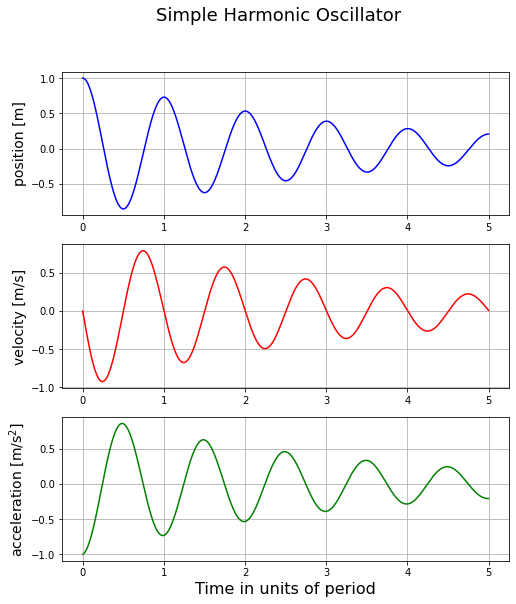

In [6]:
time_period_units = np.arange(spring.num_timesteps) * spring.dt / spring.period

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,9))
fig.suptitle('Simple Harmonic Oscillator', fontsize=18)

ax1.plot(time_period_units, spring.x_vals, color='b')
ax1.grid()
ax1.set_ylabel('position [m]', fontsize=14)

ax2.plot(time_period_units, spring.v_vals, color='r')
ax2.grid()
ax2.set_ylabel('velocity [m/s]', fontsize=14)

ax3.plot(time_period_units, spring.a_vals, color='g')
ax3.grid()
ax3.set_ylabel('acceleration [m/s$^2$]', fontsize=14)
ax3.set_xlabel('Time in units of period', fontsize=16)

### Continue spring motion from where we left off
Because our spring instance keeps all of the last timestep's conditions (e.g. in `spring.a_now`, etc.), we can continue to evolve over additional periods.  Note, however, we have to use the same number of timesteps per period for consistency.

In [7]:
#  Continue evolving for three more periods
num_periods = 3
num_timesteps_per_period = 1000
spring.evolve_spring(num_periods, num_timesteps_per_period)

### Short hand for plotting (2 points)
Make the same three-axis plot using the built-in `zip` class to decrease the amount of code you use.  Below is a simple example of how `zip` works, but I recommend uncommenting the last line to also take a look at the documentation for `zip` with `help`. 

In [8]:
# Example use of zip
mynums = np.array([1,2,3,5])
mywords = np.array(['one','two','three','five'])
myromannums = np.array(['I','II','III','V'])

for mynum, myword, myromannum in zip(mynums,mywords, myromannums) :
    print(mynum)
    print(myword)
    print(myromannum)

#help(zip)

1
one
I
2
two
II
3
three
III
5
five
V


Text(0.5, 0, 'Time in units of period')

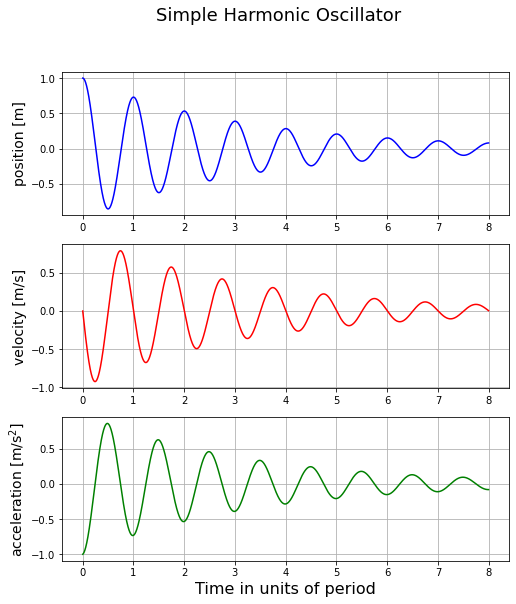

In [9]:
#  Your code using zip to make same plot as above here:
num_total_timesteps = len(spring.x_vals) # Note, spring.timesteps is the number of timesteps we recently took
time_period_units = np.arange(num_total_timesteps) * spring.dt / spring.period

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,9))  
axes = [ax1, ax2, ax3]

fig.suptitle('Simple Harmonic Oscillator', fontsize=18)
yarrays = [spring.x_vals, spring.v_vals, spring.a_vals]
ylabels = ['position [m]', 'velocity [m/s]', 'acceleration [m/s$^2$]']
colors = ['b', 'r', 'g']

# Use zip in a for floop containing no more than 3 lines in the body of the for loop
### BEGIN SOLUTION
for ax, yarray, ylabel, color in zip(axes, yarrays, ylabels, colors) :
    ax.plot(time_period_units, yarray, color=color)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=14)
### END SOLUTION
    
ax3.set_xlabel('Time in units of period', fontsize=16)

### Illustrate effects of naively switching timesteps and correct the issue (2 points)
Below, we illustrate what choosing the different timesteps per period looks like.  Increasing the number of timesteps (i.e. refining the time resolution) is in fact something that might be desireable for a given problem.  First, plot the spring behavior with the naive assumption that you can continue as before.  You will notice that the plot shows a change in period for the time correpsonding to the third call of the `evolve_spring` method.  Note - you'll need to add the same code below using zip as you did before. 

In [10]:
#  Evolve for one period with a different timestep
num_periods = 3
num_timesteps_per_period = 2000
spring.evolve_spring(num_periods, num_timesteps_per_period)

previous dt=0.0063
new dt=0.0031


Text(0.5, 0, 'Time in units of period')

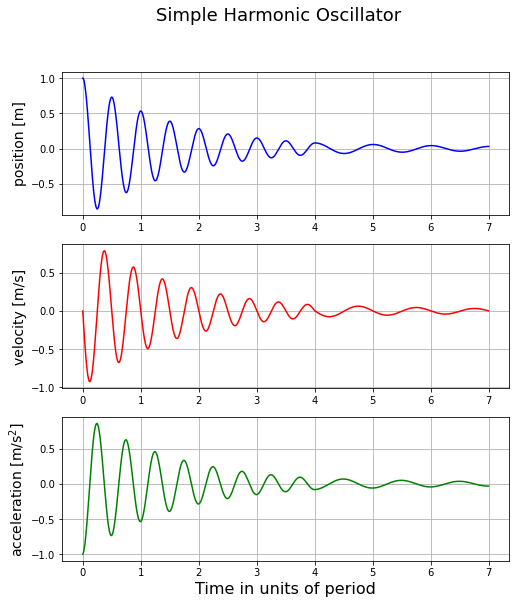

In [11]:
#  Use the same code with zip to see the effects of changing num_timesteps_per_period
num_total_timesteps = len(spring.x_vals)
time_period_units = np.arange(num_total_timesteps) * spring.dt / spring.period

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,9))  
axes = [ax1, ax2, ax3]

fig.suptitle('Simple Harmonic Oscillator', fontsize=18)
yarrays = [spring.x_vals, spring.v_vals, spring.a_vals]
ylabels = ['position [m]', 'velocity [m/s]', 'acceleration [m/s$^2$]']
colors = ['b', 'r', 'g']

# Use zip in a for floop containing no more than 3 lines in the body of the for loop
### BEGIN SOLUTION
for ax, yarray, ylabel, color in zip(axes, yarrays, ylabels, colors) :
    ax.plot(time_period_units, yarray, color=color)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=14)
### END SOLUTION
    
ax3.set_xlabel('Time in units of period', fontsize=16)

Now, take the code from the cell above, and modify it in the cell below to account for the higher time resolution to get an appropriate plot.  The crux of this is to redifine `time_period_units` so the values for time (x-axis-values) are no longer evenly spaced.   

**Hint**: You'll want to double the timesteps corresponding to points calculated from the first two calls of the method `evolve_spring`, perhaps naming this `time_period_units_before`.  Then, you'll want to keep the timesteps for the last (third) call of the method `evolve_spring`, perhaps naming this `time_period_units_before`, and this should start right after the last value of `time_period_units_before`. You can then use `np.concatenate` to create one entire `time_period_units` for plotting from this.  

**Alternative approach**: Note, there are better ways to do this, such as defining an attribute of the `Spring` that keeps track of the number of timesteps for each time `evolve_spring` has been called, paired with the corresponding `dt`.  You are welcome to try adding such an attribute to the definition of `Spring`, or you can make the correction only for the figure as described in the hint above.  If you try adding such an attribute, this could look like a list, `self.spring_evolution_config`, where each list item is a tuple (`num_timesteps`, `dt`) that gets appended every time `evolve_spring` gets called (and `_set_num_timesteps` gets called). 

Text(0.5, 0, 'Time in units of period')

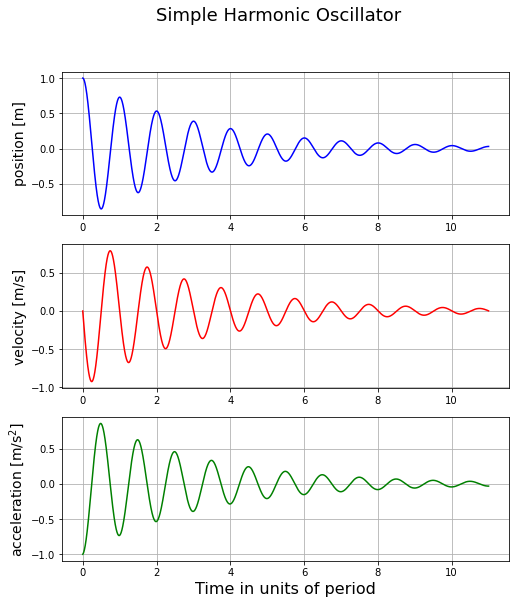

In [12]:
#  Make modifications to the previous cell of code to make an appropriate plot
### BEGIN SOLUTION
num_total_timesteps = len(spring.x_vals)

time_period_units_before = np.arange(num_total_timesteps - spring.num_timesteps) * 2 * spring.dt / spring.period
time_period_units_after = time_period_units_before[-1] + np.arange(spring.num_timesteps) * spring.dt / spring.period

time_period_units = np.concatenate([time_period_units_before, time_period_units_after])

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,9))  
axes = [ax1, ax2, ax3]

fig.suptitle('Simple Harmonic Oscillator', fontsize=18)
yarrays = [spring.x_vals, spring.v_vals, spring.a_vals]
ylabels = ['position [m]', 'velocity [m/s]', 'acceleration [m/s$^2$]']
colors = ['b', 'r', 'g']

for ax, yarray, ylabel, color in zip(axes, yarrays, ylabels, colors) :
    ax.plot(time_period_units, yarray, color=color)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize=14)
    
ax3.set_xlabel('Time in units of period', fontsize=16)
### END SOLUTION